## Install Dependencies

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Conv2D, MaxPooling2D, BatchNormalization

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

import os
import shutil

In [3]:
df = pd.read_csv('list_attribute.txt', sep="\s+", skiprows=1, usecols=['Male'])
df.loc[df['Male'] == -1, 'Male'] = 0

df

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
df = df.rename(columns={'Male': 'sex'})

df.loc[df['sex'] == 0, 'sex'] = 'female'
df.loc[df['sex'] == 1, 'sex'] = 'male'
df

In [ ]:
filenames = os.listdir('Images')
df = df[df.index.isin(filenames)]
df = df.reset_index()
df

In [ ]:
df["sex"].value_counts()

## Move images to separate folder according to its class

In [ ]:
source_directory = 'Images'
destination_directory = 'Classified'

if not os.path.exists(destination_directory):
    os.makedirs(destination_directory)

for index, row in df.iterrows():
    # Extract the "id" and "sex" values from the current row
    id_value = row['index']
    sex_value = row['sex']
    
    # Construct the file name from the "id" value
    file_name = str(id_value) # Assuming the file extension is '.jpg'
    
    # Construct the source and destination paths
    source_path = os.path.join(source_directory, file_name)
    destination_path = os.path.join(destination_directory, sex_value, file_name)
    
    # Create the destination directory if it doesn't already exist
    if not os.path.exists(os.path.join(destination_directory, sex_value)):
        os.makedirs(os.path.join(destination_directory, sex_value))
    
    # Move the file to the destination directory
    shutil.move(source_path, destination_path)

## Load Dataset

In [2]:
data = tf.keras.utils.image_dataset_from_directory('Classified', image_size=(224,224), shuffle=True)

Found 5000 files belonging to 2 classes.


In [3]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

In [4]:
batch[0].shape

(32, 224, 224, 3)

## Preprocess Dataset

In [5]:
#Scale Data
data = data.map(lambda x,y: (x/255, y))

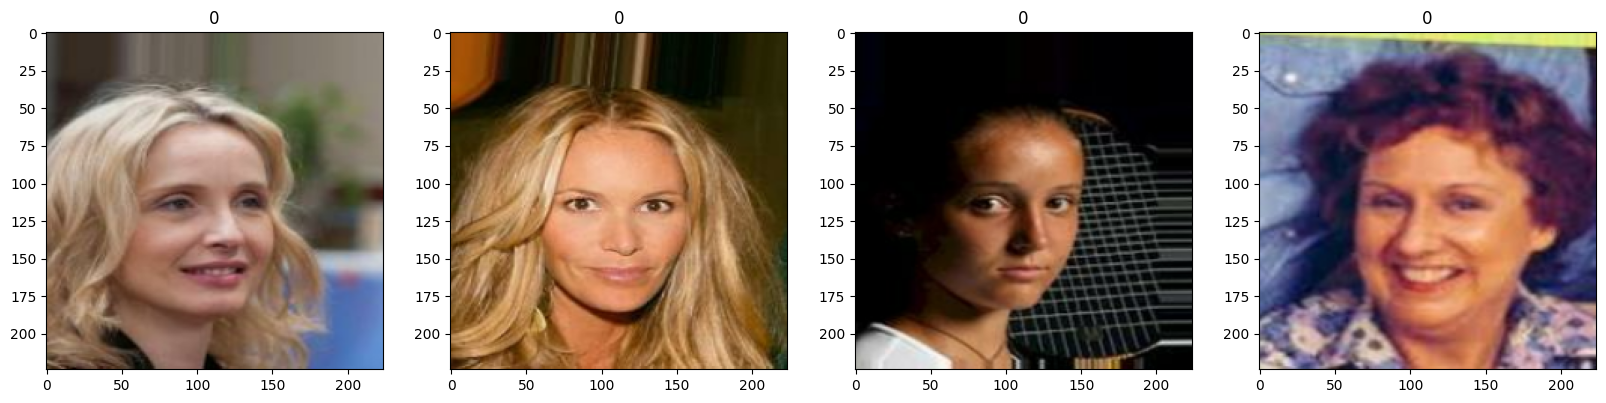

In [6]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [7]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [8]:
print(train_size)
print(val_size)
print(test_size)

109
31
15


In [9]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## Train the Model (Resnet50)

In [29]:
resnet_model = Sequential()

model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(224,224,3),
                   pooling='max',classes=2,
                   weights=None)

for layer in model.layers:
        layer.trainable=True

resnet_model.add(model)
resnet_model.add(Flatten())
resnet_model.add(BatchNormalization())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(BatchNormalization())
resnet_model.add(Dense(1, activation='sigmoid'))

In [30]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               1049088   
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 24,647,553
Trainable params: 24,589,313
Non-trainable params: 58,240
_____________________________________

In [32]:
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

In [33]:
epochs=25
hist = resnet_model.fit(
  train,
  validation_data=val,
  epochs=epochs
)

Epoch 1/25
109/109 [==============================] - 49s 401ms/step - loss: 0.6134 - accuracy: 0.6864 - val_loss: 0.7579 - val_accuracy: 0.5948
Epoch 2/25
109/109 [==============================] - 43s 397ms/step - loss: 0.4829 - accuracy: 0.7744 - val_loss: 1.4326 - val_accuracy: 0.5978
Epoch 3/25
109/109 [==============================] - 43s 396ms/step - loss: 0.3783 - accuracy: 0.8429 - val_loss: 0.5191 - val_accuracy: 0.7641
Epoch 4/25
109/109 [==============================] - 43s 397ms/step - loss: 0.2799 - accuracy: 0.8896 - val_loss: 0.4573 - val_accuracy: 0.7752
Epoch 5/25
109/109 [==============================] - 44s 400ms/step - loss: 0.2262 - accuracy: 0.9091 - val_loss: 0.2801 - val_accuracy: 0.8891
Epoch 6/25
109/109 [==============================] - 44s 402ms/step - loss: 0.2435 - accuracy: 0.9048 - val_loss: 0.3941 - val_accuracy: 0.8135
Epoch 7/25
109/109 [==============================] - 44s 401ms/step - loss: 0.2137 - accuracy: 0.9128 - val_loss: 0.2496 - val_ac

## Model Evaluation

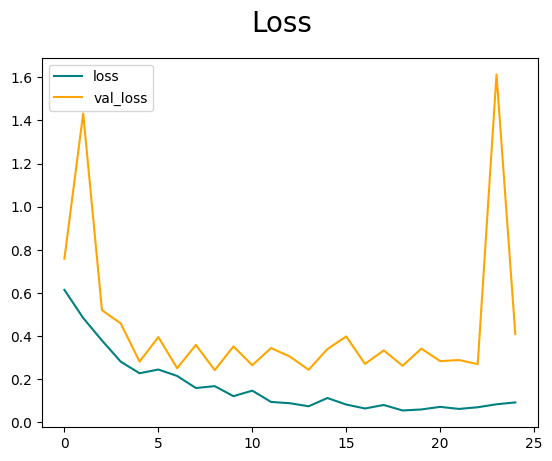

In [34]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

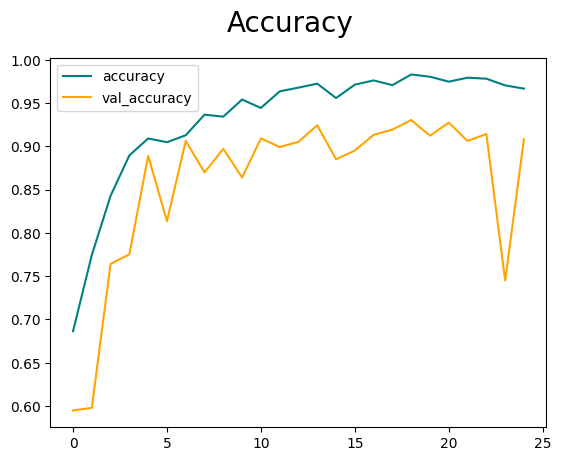

In [35]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [36]:
val_acc = hist.history['val_accuracy']
acc = hist.history['accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

print("Maksimum akurasi:  %.2f" % (np.max(val_acc)*100), "%")
print("Rata-rata akurasi:  %.2f" % (np.mean(val_acc)*100), "%")
print("Minimun loss:  %.2f" % (np.min(val_loss)*100), "%")
print("Rata-rata loss:  %.2f" % (np.mean(val_loss)*100), "%")

Maksimum akurasi:  93.04 %
Rata-rata akurasi:  85.87 %
Minimun loss:  24.06 %
Rata-rata loss:  43.97 %
